# visualization of point clouds for bounded scenes

In [1]:
import numpy as np
import cv2, os
import matplotlib.pyplot as plt
import matplotlib

import open3d as o3d

%matplotlib inline

(497728,)


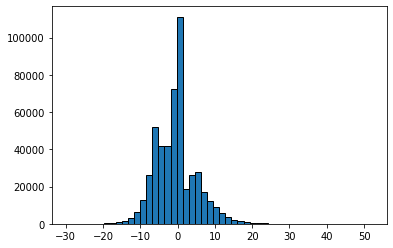

In [2]:

root = '../logs/nerf_synthetic/lego/lego_part_Sto/'

cam_train = root + 'cam_train.npz'
cam_test = root + 'cam_test.npz'
# coarse_path = root + 'fine.npz'
fine_path = root + 'fine.npz'
fine_data = np.load(fine_path)

def softplus_np(x): return np.log1p(np.exp(x))
def normalize(x, max, min): return (x - min)/(max-min)

data = np.load(fine_path)
density_raw = data['density']
density_std = data['density_std']


mask = (density_std<0)
print(density_raw[mask].shape)

eps_den = np.random.normal(size=[1,1,1,12])
density_samples = density_raw[...,None] + eps_den * density_std[...,None]

# alpha_samples = 1 - np.exp(-softplus_np(density_samples))

shift = -4.59
interval = 0.5
alpha_samples = 1 - np.exp(-softplus_np(density_samples + shift) * interval)

alpha_std = alpha_samples.std(-1)

# print(density_std.max())

plt.hist(density_raw[mask].reshape(-1), bins=50, edgecolor='black')
plt.show()


In [3]:
# show the bounding box defined by cameras, here each cam:(5,3) represents the coordiantes of five points
if cam_train:
    cam_train = np.load(cam_train)
    xyz_min = cam_train['xyz_min']
    xyz_max = cam_train['xyz_max']
    print('xyz box:',xyz_min, xyz_max)
    cam_lst_train = cam_train['cam_lst']
    cam_test = np.load(cam_test)
    cam_lst_test = cam_test['cam_lst']
    cam_frustrm_lst = []
    # select initial views
    print(cam_lst_train.shape)
    for cam in cam_lst_train:
        for i in range(1,len(cam)): # shorten the line length of the shown cam frustrm
            t = 0.1 # scale coefficient
            cam[i] = cam[i]*t + cam[0]*(1-t)
        cam_frustrm = o3d.geometry.LineSet()
        cam_frustrm.points = o3d.utility.Vector3dVector(cam)
        if len(cam) == 5:
            cam_frustrm.colors = o3d.utility.Vector3dVector([[0.5,0.5,0.5] for i in range(8)])
            cam_frustrm.lines = o3d.utility.Vector2iVector([[0,1],[0,2],[0,3],[0,4],[1,2],[2,4],[4,3],[3,1]])
        elif len(cam) == 8:
            cam_frustrm.colors = o3d.utility.Vector3dVector([[0.5,0.5,0.5] for i in range(12)])
            cam_frustrm.lines = o3d.utility.Vector2iVector([
                [0,1],[1,3],[3,2],[2,0],
                [4,5],[5,7],[7,6],[6,4],
                [0,4],[1,5],[3,7],[2,6],
            ])
        cam_frustrm_lst.append(cam_frustrm)
    for cam in cam_lst_test:
        for i in range(1,len(cam)): # shorten the line length of the shown cam frustrm
            t = 0.1 # scale coefficient
            cam[i] = cam[i]*t + cam[0]*(1-t)
        cam_frustrm = o3d.geometry.LineSet()
        cam_frustrm.points = o3d.utility.Vector3dVector(cam)
        if len(cam) == 5:
            cam_frustrm.colors = o3d.utility.Vector3dVector([[0.5,0,0] for i in range(8)])
            cam_frustrm.lines = o3d.utility.Vector2iVector([[0,1],[0,2],[0,3],[0,4],[1,2],[2,4],[4,3],[3,1]])
        elif len(cam) == 8:
            cam_frustrm.colors = o3d.utility.Vector3dVector([[0.5,0.5,0.5] for i in range(12)])
            cam_frustrm.lines = o3d.utility.Vector2iVector([
                [0,1],[1,3],[3,2],[2,0],
                [4,5],[5,7],[7,6],[6,4],
                [0,4],[1,5],[3,7],[2,6],
            ])
        # cam_frustrm_lst.append(cam_frustrm)
else:
    cam_frustrm_lst = []

# select initial views
# cam_frustrm_lst_init = [cam_frustrm_lst[i] for i in [0,1,2,3,4,5,6,7,61,62,63,64,65,66,67,112,113,114,115,116,117,118]]

aabb_01 = np.array([[0, 0, 0],
                    [0, 0, 1],
                    [0, 1, 1],
                    [0, 1, 0],
                    [1, 0, 0],
                    [1, 0, 1],
                    [1, 1, 1],
                    [1, 1, 0]])
out_bbox = o3d.geometry.LineSet()
out_bbox.points = o3d.utility.Vector3dVector(xyz_min + aabb_01 * (xyz_max - xyz_min))
out_bbox.colors = o3d.utility.Vector3dVector([[1,0,0] for i in range(12)])
out_bbox.lines = o3d.utility.Vector2iVector([[0,1],[1,2],[2,3],[3,0],[4,5],[5,6],[6,7],[7,4],[0,4],[1,5],[2,6],[3,7]]) # connect points by this order

def change_background_to_black(vis):
    opt = vis.get_render_option()
    opt.background_color = np.asarray([0, 0, 0])
    return False

# o3d.visualization.draw_geometries_with_key_callbacks([
#     o3d.geometry.TriangleMesh.create_coordinate_frame(size=(xyz_max-xyz_min).min()*0.1, origin=xyz_min),
#     out_bbox, *cam_frustrm_lst,
# ], {ord("K"): change_background_to_black})

xyz box: [-2.7696204 -2.4025354 -2.583727 ] [2.7798443 2.8522933 1.7721584]
(35, 5, 3)


In [4]:
# show the bounding box defined by fine model 
xyz_min_fine = fine_data['xyz_min_fine']
xyz_max_fine = fine_data['xyz_max_fine']
# xyz_shift = (xyz_max_fine - xyz_min_fine) * (1.05 - 1) / 2
# xyz_min_fine -= xyz_shift
# xyz_max_fine += xyz_shift
print('xyz fine box:',xyz_min_fine, xyz_max_fine)

def set_color_gradient_for_point_clouds(xyz_norm):

    attribute_values = xyz_norm[:, 2]  # Using the Z-coordinate as an attribute
    # Normalize the attribute values
    normalized_values = (attribute_values - attribute_values.min()) / (attribute_values.max() - attribute_values.min())
    # Choose a color map
    color_map = matplotlib.cm.viridis
    # Create a function to map normalized values to colors
    color_mapping_function = lambda x: color_map(x)[:3]  # Keep only RGB values
    # Apply colors to points
    colored_points = np.array([color_mapping_function(val) for val in normalized_values])

    return colored_points

aabb_01 = np.array([[0, 0, 0],
                    [0, 0, 1],
                    [0, 1, 1],
                    [0, 1, 0],
                    [1, 0, 0],
                    [1, 0, 1],
                    [1, 1, 1],
                    [1, 1, 0]])
out_bbox1 = o3d.geometry.LineSet()
out_bbox1.points = o3d.utility.Vector3dVector(xyz_min_fine + aabb_01 * (xyz_max_fine - xyz_min_fine))
out_bbox1.colors = o3d.utility.Vector3dVector([[0,1,0] for i in range(12)])
out_bbox1.lines = o3d.utility.Vector2iVector([[0,1],[1,2],[2,3],[3,0],[4,5],[5,6],[6,7],[7,4],[0,4],[1,5],[2,6],[3,7]]) # connect points by this order

# density points

xyz_scale_min, xyz_scale_max = xyz_min, xyz_max
xyz_scale_min, xyz_scale_max = xyz_min_fine, xyz_max_fine

target = fine_data['alpha']
# target = density_std
# xyz = np.stack((density_std != 1).nonzero(), -1)
# print(xyz.shape)
# thres = np.percentile(target,95)
thres = 0.01
xyz = np.stack((target > thres).nonzero(), -1)
xyz_norm = xyz / target.shape * (xyz_scale_max - xyz_scale_min) + xyz_scale_min
print('xyz.shape:',xyz.shape)
color = fine_data['rgb'][xyz[:,0], xyz[:,1], xyz[:,2]][:,:3]
# color = set_color_gradient_for_point_clouds(xyz_norm)

pcd0 = o3d.geometry.PointCloud()
pcd0.points = o3d.utility.Vector3dVector(xyz_norm)
pcd0.colors = o3d.utility.Vector3dVector(color)
voxel_grid_0 = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd0, voxel_size=max((xyz_scale_max - xyz_scale_min) / target.shape))

# uncertainty points
target, thres = fine_data['uncertainty_VH'], 0
# target = maskout(target, xyz_min, xyz_max, xyz_fine_min, xyz_fine_max)
xyz_VH = np.stack((target > thres).nonzero(), -1)[::5]
xyz_VH_norm = xyz_VH / target.shape * (xyz_scale_max - xyz_scale_min) + xyz_scale_min
print('xyz_VH.shape:',xyz_VH.shape)
color_VH = [[0.5,0,0]]*xyz_VH.shape[0]

pcd1 = o3d.geometry.PointCloud()
pcd1.points = o3d.utility.Vector3dVector(xyz_VH_norm)
pcd1.colors = o3d.utility.Vector3dVector(color_VH)
voxel_grid_1 = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd1, voxel_size=max((xyz_scale_max - xyz_scale_min) / target.shape))
# voxel_grid_1 = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd1, voxel_size=0.01)

def change_background_to_black(vis):
    opt = vis.get_render_option()
    opt.background_color = np.asarray([0, 0, 0])
    return False

o3d.visualization.draw_geometries_with_key_callbacks([
    o3d.geometry.TriangleMesh.create_coordinate_frame(size=(xyz_max-xyz_min).min()*0.1, origin=xyz_min),
    voxel_grid_0, *cam_frustrm_lst,
], {ord("K"): change_background_to_black})

xyz fine box: [-0.73649836 -1.2479888  -0.5982537 ] [0.7467222 1.1924748 1.1035806]
xyz.shape: (143461, 3)


In [ ]:
export_mesh=0
if export_mesh:
    # visualize mesh
    density = fine_data['density']

    # padding to make a cube 
    long_side = np.array(density.shape).max()
    padded_density = np.pad(density, [(long_side - density.shape[0], 0), (long_side - density.shape[1], 0), (long_side - density.shape[2], 0)], mode='constant')

    # perform marching cube algorithm to retrieve vertices and triangle mesh
    import mcubes
    thres = np.percentile(density,90)
    vertices, triangles = mcubes.marching_cubes(padded_density, thres)
    mcubes.export_obj(vertices, triangles, 'sphere.obj')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Sample data: points and associated attribute values
points = np.random.rand(100, 3)  # Example 3D points
attribute_values = points[:, 2]  # Using the Z-coordinate as an attribute

# Normalize the attribute values
normalized_values = (attribute_values - attribute_values.min()) / (attribute_values.max() - attribute_values.min())

# Choose a color map
color_map = cm.viridis

# Create a function to map normalized values to colors
color_mapping_function = lambda x: color_map(x)

# Apply colors to points
colored_points = color_mapping_function(normalized_values)

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colored_points)

plt.show()
